In [6]:
import numpy as np
import time
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [116]:
class DeepNeuralNetwork():
    def __init__(self, size, epoch=10, lr=1e-4):
        self.size = size
        self.epoch = epoch
        self.lr = lr
        self.loss = []
    
        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()
    
    
    ##Initialization
    def initialization(self):
        # number of nodes in each layer
        input_layer = self.size[0] #13
        hidden1 = self.size[1] #24
        hidden2 = self.size[2] #48
        hidden3 = self.size[3] #24
        output_layer = self.size[4] #1
    
        params = {
            'W1': np.random.randn(hidden1, input_layer),
            'W2': np.random.randn(hidden2, hidden1),
            'W3': np.random.randn(hidden3, hidden2),
            'W4': np.random.randn(output_layer, hidden3),

            #'B1': np.random.randn(hidden1, 1),
            #'B2': np.random.randn(hidden2, 1),
            #'B3': np.random.randn(hidden3, 1),
            #'B4': np.random.randn(output_layer, 1)
        }
        return params


    def relu(self, x, derivative=False):
        if derivative==True:
            x[x > 0] = 1
            x[x <= 0] = 0
            return x
        return np.maximum(0, x)


    ### Feedforward
    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['I'] = x_train.reshape(13, 1)

        # input layer to hidden layer 1
        params['A1'] = np.dot(params["W1"], params['I'])
        #params['A1'] = np.dot(params["W1"], params['I']) + params['B1']
        params['R1'] = self.relu(params['A1'])

        # hidden layer 1 to hidden layer 2
        params['A2'] = np.dot(params["W2"], params['A1'])
        #params['A2'] = np.dot(params["W2"], params['A1']) + params['B2']
        params['R2'] = self.relu(params['A2'])

        # hidden layer 2 to hidden layer 3
        params['A3'] = np.dot(params["W3"], params['A2']) 
        #params['A3'] = np.dot(params["W3"], params['A2']) + params['B3'] 
        params['R3'] = self.relu(params['A3'])

        # hidden layer 3 to output layer
        params['O'] = np.dot(params['W4'], params['R3'])
        #params['O'] = np.dot(params['W4'], params['R3']) + params['B4']

        return params['O']


    def lossfunction(self, output, y_train):
        return (output-y_train)**2



    ### Backpropagation
    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        # Calculate W4 update
        error_O = output - y_train

        # Calculate W3 update
        error_R3 = np.multiply( np.dot(params['W4'].T, error_O), self.relu(params['A3'], derivative=True) )

        # Calculate W2 update
        error_R2 = np.multiply( np.dot(params['W3'].T, error_R3), self.relu(params['A2'], derivative=True) )

        # Calculate W1 update
        error_R1 = np.multiply( np.dot(params['W2'].T, error_R2), self.relu(params['A1'], derivative=True) )
        
        
        change_w['W1'] = np.dot(params['I'], error_R1.T).T
        change_w['W2'] = np.dot(params['R1'], error_R2.T).T
        change_w['W3'] = np.dot(params['R2'], error_R3.T).T
        change_w['W4'] = np.dot(params['R3'], error_O.T).T
        return change_w


    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.lr * value


    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epoch):
            loss_list = []
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x.reshape(13, 1))
                changes_to_w = self.backward_pass(y.reshape(1, 1), output)
                self.update_network_parameters(changes_to_w)
                loss_list.append(self.lossfunction(float(self.forward_pass(x.reshape(13, 1))), float(y)))
            self.loss.append(np.mean(loss_list))
            if (iteration-1) % 100 == 0:
                print('Epoch: {0}, Time Spent: {1:.2f}s'.format(
                    iteration+1, time.time() - start_time
                ))


In [ ]:
boston = load_boston()
X = boston.data #(506, 13)
Y = boston.target.T #(506, )
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)
dnn = DeepNeuralNetwork(size=[13, 24, 48, 24, 1], epoch=10000, lr=1e-9)
dnn.train(X_train, Y_train, X_val, Y_train)


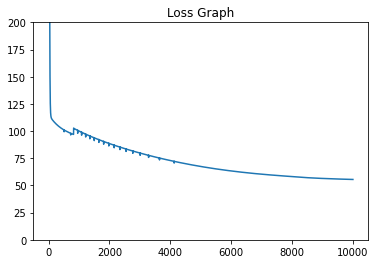

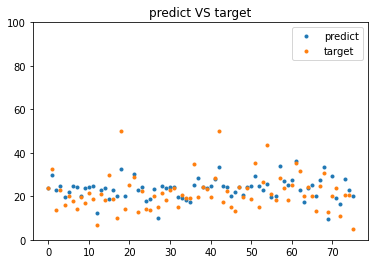

In [155]:
import matplotlib.pyplot as plt

predict = []
for i in range(len(X_val)):
    predict.append(float(dnn.forward_pass(X_val[i])))


plt.figure()
plt.plot(dnn.loss)
plt.title("Loss Graph")
plt.ylim(0, 200)
plt.show()

plt.figure()
plt.plot(predict, ".", label="predict")
plt.plot(Y_val, ".", label="target")
plt.title("predict VS target")
plt.ylim(0, 100)
plt.legend()
plt.show()

#plt.figure()
#plt.plot(predict - Y_val, ".")
#plt.ylim(-50, 50)
#plt.title("predict - target")
#plt.show()